# Convolutional Neural Networks For Image Recognition

## Setup and Imports

In [1]:
# Setup
from __future__ import division, print_function, unicode_literals

# Imports
import numpy as np
import numpy.random as rnd
import os

# To make make consistent across code blocks
rnd.seed(42)

# Ploting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Saving Parameters
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "data", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

**Import Tensorflow**

In [3]:
import tensorflow as tf

**Images Plot Functions**

In [2]:
#Ploting grayscale and RGB images
def plot_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# Reshapes a 1024x3 image to plot it as a 32x32x3 image
def plot_image_adjust(image_adj, height, width, channels):
    # Create array for image
    data = np.zeros((height, width, channels))
    for k in range(channels):
        for j in range(width):
            for l in range(height):
                data[j][l][k] = image_adj[int(l + j*32)][k] / 255
    plt.imshow(data, interpolation="nearest")
    plt.axis("off")

**Data Loading Functions**

In [44]:
# Loads and Decodes Data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Takes in the local path of the data file and returns an array of data
# Assumes data is in the format oulined by cifar 100
# For more info, checkout: https://www.cs.toronto.edu/~kriz/cifar.html
def load_data(path, length, channels, reduced):
    train = unpickle(path)
    
    # --------------------------------------------------------------------
    # Restrict data used to only that with coarse labels 5 or 6
    # Corresponding to Household Electronics and Furniture
    # --------------------------------------------------------------------
    if(reduced):
        L1 = 5 # Desired label - household electronics
        L2 = 6 # Desired label - household furniture

        # Find length of reduced data set
        count = 0
        for i in range(len(train[b'data'])):
             if train[b'coarse_labels'][i]==L1 or train[b'coarse_labels'][i]==L2:
                count += 1

        # Create arrays for our data and labels to be held in
        data = np.zeros((count, length, channels))
        labels = np.zeros((count, 2))

        # Store file data in arrays data and labels if it matches the
        # reduced set parameters
        count = 0;
        for i in range(len(train[b'data'])):
            if train[b'coarse_labels'][i]==L1 or train[b'coarse_labels'][i]==L2:
                
                for j in range(channels):
                    for k in range(length):
                        data[count][k][j] = train[b'data'][i][k+j*1024]
                labels[count][0] = train[b'coarse_labels'][i]
                labels[count][1] = train[b'fine_labels'][i]
                count += 1
    
    # Otherwise return full data set           
    else:
        data = train[b'data']
        labels = [train[b'coarse_labels'], train[b'fine_labels']]
    
    # Return data and 2D Labels [coarse, fine]
    return data, data2, labels

**Load Train Data**

In [45]:
# Define paths and dimensions for data
train_path = "data/cifar-100-python/train"
length = 1024
channels = 3
reduced = True

# Get the reduced set of data and store it in data and labels
data, labels = load_data(train_path, length, channels, reduced)

**Load Test Data**

In [40]:
test_path  = "data/cifar-100-python/test"

test_data, test_labels = load_data(test_path, length, channels, reduced)

**Data Verification**

[  5.  86.]


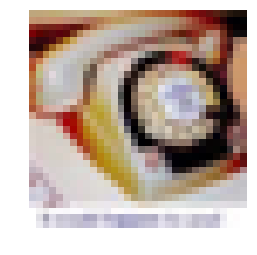

In [42]:
# Print out the label and picture of the first element of training data as a check
print(labels[0])
plot_image_adjust(data[0], 32, 32, 3)

# Print out the label and picture of the first element of testing data as a check
print(test_labels[0])
plot_image_adjust(test_data[0], 32, 32, 3)